<a href="https://colab.research.google.com/github/fahimkha/AI-with-Python/blob/main/Vehicle_Image_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow pillow opencv-python


In [2]:
!pip install bing-image-downloader



In [5]:
from bing_image_downloader import downloader

classes = ["airplane", "bicycle", "bus"]

for cls in classes:
    downloader.download(
        cls,
        limit=20,              # number of images per class
        output_dir="raw_data2",
        adult_filter_off=True,
        force_replace=False,
        timeout=60
    )


[%] Downloading Images to /content/raw_data2/airplane


[!!]Indexing page: 1

[%] Indexed 33 Images on Page 1.


[%] Downloading Image #1 from https://images.pexels.com/photos/13275759/pexels-photo-13275759.jpeg?cs=srgb&amp;dl=pexels-nguy-n-vu-192437181-13275759.jpg&amp;fm=jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://images.pexels.com/photos/13275758/pexels-photo-13275758.jpeg?cs=srgb&amp;dl=pexels-nguy-n-vu-192437181-13275758.jpg&amp;fm=jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://images.pexels.com/photos/358319/pexels-photo-358319.jpeg?cs=srgb&amp;dl=air-air-travel-airbus-358319.jpg&amp;fm=jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images.pexels.com/photos/113585/pexels-photo-113585.jpeg?cs=srgb&amp;dl=aeroplane-aircraft-airplane-113585.jpg&amp;fm=jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://images.pexels.com/photos/912050/pexels-photo-912050.jpeg?cs=srgb&amp;dl=aeroplane-aircraft-airline-912050.jpg&amp

In [12]:
import os

base_dirs = [
    "dataset/train/airplane",
    "dataset/train/bicycle",
    "dataset/train/bus",
    "dataset/test/airplane",
    "dataset/test/bicycle",
    "dataset/test/bus"
]

for d in base_dirs:
    os.makedirs(d, exist_ok=True)


In [13]:
import os, shutil, random

def split_data(source, train_dir, test_dir, split=0.8):
    files = [
        f for f in os.listdir(source)
        if os.path.isfile(os.path.join(source, f))
    ]

    random.shuffle(files)
    train_size = int(len(files) * split)

    for i, file in enumerate(files):
        src = os.path.join(source, file)
        if i < train_size:
            dst = os.path.join(train_dir, file)
        else:
            dst = os.path.join(test_dir, file)
        shutil.copy(src, dst)


In [14]:
split_data("raw_data/airplane", "dataset/train/airplane", "dataset/test/airplane")
split_data("raw_data/bicycle", "dataset/train/bicycle", "dataset/test/bicycle")
split_data("raw_data/bus", "dataset/train/bus", "dataset/test/bus")


In [15]:
!ls dataset/train/airplane | wc -l
!ls dataset/test/airplane | wc -l


8
3


In [16]:
!ls dataset/train/bicycle | wc -l
!ls dataset/test/bicycle | wc -l


8
3


In [20]:
!ls dataset/train/bus | wc -l
!ls dataset/test/bus | wc -l

8
2


In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


In [22]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    "dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data = test_gen.flow_from_directory(
    "dataset/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

print("Class labels:", train_data.class_indices)


Found 24 images belonging to 3 classes.
Found 8 images belonging to 3 classes.
Class labels: {'airplane': 0, 'bicycle': 1, 'bus': 2}


In [23]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.4167 - loss: 2.0870 - val_accuracy: 0.3750 - val_loss: 7.0491
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.2500 - loss: 4.7908 - val_accuracy: 0.2500 - val_loss: 2.2538
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.3264 - loss: 1.6577 - val_accuracy: 0.3750 - val_loss: 1.2258
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4028 - loss: 1.0181 - val_accuracy: 0.5000 - val_loss: 0.9461
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6250 - loss: 0.8354 - val_accuracy: 0.6250 - val_loss: 0.8175
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8750 - loss: 0.6752 - val_accuracy: 0.7500 - val_loss: 0.8004
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7917 - loss: 0.6902 - val_accuracy: 0.6250 - val_loss: 0.7273
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8472 - loss: 0.5020 - val_accuracy: 0.6250 - val_loss: 0.5738
Epoch 9/10
2/2 

In [25]:
loss, accuracy = model.evaluate(test_data)
print("Test Accuracy:", accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step - accuracy: 0.7500 - loss: 0.6007
Test Accuracy: 0.75


In [26]:
from google.colab import files
files.upload()


Saving test.jpg to test.jpg


{'test.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x02\x02\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x02\x02\x02\x02\x01\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\xff\xdb\x00C\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\x02\xff\xc0\x00\x11\x08\x02\xab\x04\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0

In [27]:
import cv2
import numpy as np

classes = ["airplane", "bicycle", "bus"]

img = cv2.imread("test.jpg")
img = cv2.resize(img, (128,128))
img = img / 255.0
img = np.reshape(img, (1,128,128,3))

prediction = model.predict(img)
print("Prediction:", classes[np.argmax(prediction)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Prediction: bicycle


In [28]:
from google.colab import files
files.upload()


Saving test.jpg to test (1).jpg


{'test (1).jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe1\x00SExif\x00\x00II*\x00\x08\x00\x00\x00\x03\x00\x98\x82\x02\x00\t\x00\x00\x002\x00\x00\x00\x1a\x01\x05\x00\x01\x00\x00\x00;\x00\x00\x00\x1b\x01\x05\x00\x01\x00\x00\x00C\x00\x00\x00\x00\x00\x00\x00Ilda masa,\x01\x00\x00\x01\x00\x00\x00,\x01\x00\x00\x01\x00\x00\x00\xff\xe1\x052http://ns.adobe.com/xap/1.0/\x00<?xpacket begin="\xef\xbb\xbf" id="W5M0MpCehiHzreSzNTczkc9d"?>\n<x:xmpmeta xmlns:x="adobe:ns:meta/">\n\t<rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">\n\t\t<rdf:Description rdf:about="" xmlns:photoshop="http://ns.adobe.com/photoshop/1.0/" xmlns:Iptc4xmpCore="http://iptc.org/std/Iptc4xmpCore/1.0/xmlns/"   xmlns:GettyImagesGIFT="http://xmp.gettyimages.com/gift/1.0/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:plus="http://ns.useplus.org/ldf/xmp/1.0/"  xmlns:iptcExt="http://iptc.org/std/Iptc4xmpExt/2008-02-29/" xmlns:xmpRights="http://ns.adobe.com/xap/1.0/rights/" dc:Rights

In [31]:
from google.colab import files
files.upload()


Saving test.jpg to test.jpg


{'test.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe1\x00SExif\x00\x00II*\x00\x08\x00\x00\x00\x03\x00\x98\x82\x02\x00\t\x00\x00\x002\x00\x00\x00\x1a\x01\x05\x00\x01\x00\x00\x00;\x00\x00\x00\x1b\x01\x05\x00\x01\x00\x00\x00C\x00\x00\x00\x00\x00\x00\x00Ilda masa,\x01\x00\x00\x01\x00\x00\x00,\x01\x00\x00\x01\x00\x00\x00\xff\xe1\x052http://ns.adobe.com/xap/1.0/\x00<?xpacket begin="\xef\xbb\xbf" id="W5M0MpCehiHzreSzNTczkc9d"?>\n<x:xmpmeta xmlns:x="adobe:ns:meta/">\n\t<rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">\n\t\t<rdf:Description rdf:about="" xmlns:photoshop="http://ns.adobe.com/photoshop/1.0/" xmlns:Iptc4xmpCore="http://iptc.org/std/Iptc4xmpCore/1.0/xmlns/"   xmlns:GettyImagesGIFT="http://xmp.gettyimages.com/gift/1.0/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:plus="http://ns.useplus.org/ldf/xmp/1.0/"  xmlns:iptcExt="http://iptc.org/std/Iptc4xmpExt/2008-02-29/" xmlns:xmpRights="http://ns.adobe.com/xap/1.0/rights/" dc:Rights="Il

In [32]:
import cv2
import numpy as np

classes = ["airplane", "bicycle", "bus"]

img = cv2.imread("test.jpg")
img = cv2.resize(img, (128,128))
img = img / 255.0
img = np.reshape(img, (1,128,128,3))

prediction = model.predict(img)
print("Prediction:", classes[np.argmax(prediction)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction: bicycle


In [33]:
from google.colab import files
files.upload()


Saving test.jpg to test.jpg


{'test.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe1\x00\x02\xff\xdb\x00\x84\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc2\x00\x11\x08\x02\xbc\x04\x1f\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x005\x00\x01\x00\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x02\x03\x05\x06\x07\x08\x01\x01\x01\x01\x00\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x04\x05\x03\x06\x07\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x00\xef\xe0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

In [34]:
import cv2
import numpy as np

classes = ["airplane", "bicycle", "bus"]

img = cv2.imread("test.jpg")
img = cv2.resize(img, (128,128))
img = img / 255.0
img = np.reshape(img, (1,128,128,3))

prediction = model.predict(img)
print("Prediction:", classes[np.argmax(prediction)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: bicycle


In [35]:
from google.colab import files
files.upload()


Saving test.jpg to test.jpg


{'test.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe1\x00VExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x04\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00>\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00F\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x02\x13\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01,\x00\x00\x00\x01\x00\x00\x01,\x00\x00\x00\x01\xff\xed\x00,Photoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x00\x0f\x1c\x01Z\x00\x03\x1b%G\x1c\x01\x00\x00\x02\x00\x04\x00\xff\xe1\x0c\x81http://ns.adobe.com/xap/1.0/\x00<?xpacket begin=\'\xef\xbb\xbf\' id=\'W5M0MpCehiHzreSzNTczkc9d\'?>\n<x:xmpmeta xmlns:x=\'adobe:ns:meta/\' x:xmptk=\'Image::ExifTool 10.10\'>\n<rdf:RDF xmlns:rdf=\'http://www.w3.org/1999/02/22-rdf-syntax-ns#\'>\n\n <rdf:Description rdf:about=\'\'\n  xmlns:tiff=\'http://ns.adobe.com/tiff/1.0/\'>\n  <tiff:ResolutionUnit>2</tiff:ResolutionUnit>\n  <tiff:XResolution>300/1</tiff:XResolution>\n  <tiff:YResolution>300/1</tiff:YResolution>\n </rd

In [36]:
import cv2
import numpy as np

classes = ["airplane", "bicycle", "bus"]

img = cv2.imread("test.jpg")
img = cv2.resize(img, (128,128))
img = img / 255.0
img = np.reshape(img, (1,128,128,3))

prediction = model.predict(img)
print("Prediction:", classes[np.argmax(prediction)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction: bicycle


In [38]:
from PIL import Image

def check_images(folder):
    for cls in ["airplane","bicycle","bus"]:
        path = os.path.join(folder, cls)
        for f in os.listdir(path):
            try:
                Image.open(os.path.join(path,f)).verify()
            except:
                print("Bad image:", os.path.join(path,f))

check_images("dataset/train")
check_images("dataset/test")


In [39]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [40]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(3, activation="softmax")
])


In [41]:
img = cv2.imread("test.jpg")
img = cv2.resize(img, (128,128))
img = img / 255.0
img = np.reshape(img, (1,128,128,3))
pred = model.predict(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


In [43]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(3, activation="softmax")
])


In [44]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [45]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15
)


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.2708 - loss: 2.0396 - val_accuracy: 0.3750 - val_loss: 1.4654
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.3889 - loss: 1.1466 - val_accuracy: 0.3750 - val_loss: 1.1318
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.2847 - loss: 1.1721 - val_accuracy: 0.3750 - val_loss: 1.1029
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3819 - loss: 1.0892 - val_accuracy: 0.6250 - val_loss: 1.0141
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6944 - loss: 0.9298 - val_accuracy: 0.6250 - val_loss: 0.8816
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6944 - loss: 0.7369 - val_accuracy: 0.6250 - val_loss: 0.7623
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7014 - loss: 0.6792 - val_accuracy: 0.6250 - val_loss: 0.6407
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6250 - loss: 0.6510 - val_accuracy: 0.5000 - val_loss: 0.7817
Epoch 9/15
2/2 

In [46]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import os

# -------------------------------
# 1️⃣ Parameters
# -------------------------------
IMG_SIZE = (128,128)
BATCH_SIZE = 16
EPOCHS = 15
CLASSES = ["airplane", "bicycle", "bus"]

# -------------------------------
# 2️⃣ Data Generators
# -------------------------------
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    "dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data = test_gen.flow_from_directory(
    "dataset/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# -------------------------------
# 3️⃣ Compute class weights (for imbalance)
# -------------------------------
labels = train_data.classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# -------------------------------
# 4️⃣ Build the CNN Model
# -------------------------------
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(len(CLASSES), activation="softmax")
])

# -------------------------------
# 5️⃣ Compile
# -------------------------------
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -------------------------------
# 6️⃣ Train
# -------------------------------
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCHS,
    class_weight=class_weights
)

# -------------------------------
# 7️⃣ Evaluate
# -------------------------------
loss, acc = model.evaluate(test_data)
print("✅ Test Accuracy:", acc)

# -------------------------------
# 8️⃣ Save Model
# -------------------------------
model.save("vehicle_ai_model.h5")
print("✅ Model saved: vehicle_ai_model.h5")


Found 24 images belonging to 3 classes.
Found 8 images belonging to 3 classes.
Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,803 (24.86 MB)

 Trainable params: 6,516,803 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.3472 - loss: 2.1321 - val_accuracy: 0.3750 - val_loss: 1.6046
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4028 - loss: 1.3332 - val_accuracy: 0.2500 - val_loss: 1.3754
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.3472 - loss: 1.1296 - val_accuracy: 0.5000 - val_loss: 1.0015
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4861 - loss: 0.8782 - val_accuracy: 0.6250 - val_loss: 0.9282
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5972 - loss: 0.8056 - val_accuracy: 0.5000 - val_loss: 0.8615
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.8194 - loss: 0.6618 - val_accuracy: 0.6250 - val_loss: 0.7927
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7500 - loss: 0.6301 - val_accuracy: 0.6250 - val_loss: 0.7249
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8750 - loss: 0.4221 - val_accuracy: 0.6250 - val_loss: 0.7783
Epoch 9/15
2/2 ━

✅ Test Accuracy: 0.625
✅ Model saved: vehicle_ai_model.h5


In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import os

# -------------------------------
# 1️⃣ Parameters
# -------------------------------
IMG_SIZE = (128,128)
BATCH_SIZE = 16
EPOCHS = 15
CLASSES = ["airplane", "bicycle", "bus"]

# -------------------------------
# 2️⃣ Data Generators
# -------------------------------
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    "dataset/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data = test_gen.flow_from_directory(
    "dataset/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# -------------------------------
# 3️⃣ Compute class weights (for imbalance)
# -------------------------------
labels = train_data.classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# -------------------------------
# 4️⃣ Build the CNN Model
# -------------------------------
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(len(CLASSES), activation="softmax")
])

# -------------------------------
# 5️⃣ Compile
# -------------------------------
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -------------------------------
# 6️⃣ Train
# -------------------------------
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCHS,
    class_weight=class_weights
)

# -------------------------------
# 7️⃣ Evaluate
# -------------------------------
loss, acc = model.evaluate(test_data)
print("✅ Test Accuracy:", acc)

# -------------------------------
# 8️⃣ Save Model
# -------------------------------
model.save("vehicle_ai_model.h5")
print("✅ Model saved: vehicle_ai_model.h5")


Found 24 images belonging to 3 classes.
Found 8 images belonging to 3 classes.
Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,803 (24.86 MB)

 Trainable params: 6,516,803 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.2986 - loss: 1.4618 - val_accuracy: 0.5000 - val_loss: 1.3197
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.2083 - loss: 1.5718 - val_accuracy: 0.3750 - val_loss: 1.2273
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3472 - loss: 1.0580 - val_accuracy: 0.5000 - val_loss: 0.9913
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6944 - loss: 0.9348 - val_accuracy: 0.5000 - val_loss: 0.9618
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4514 - loss: 0.9012 - val_accuracy: 0.6250 - val_loss: 0.7569
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.6944 - loss: 0.7075 - val_accuracy: 0.8750 - val_loss: 0.6910
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7569 - loss: 0.6133 - val_accuracy: 0.5000 - val_loss: 0.6669
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7292 - loss: 0.5219 - val_accuracy: 0.6250 - val_loss: 0.6163
Epoch 9/15
2/2 ━

✅ Test Accuracy: 0.625
✅ Model saved: vehicle_ai_model.h5


Saving test.jpg to test (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
Predicted class: bicycle


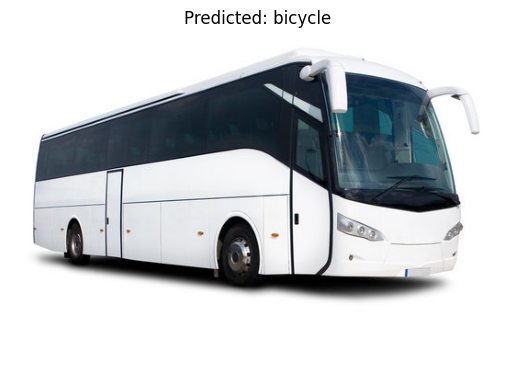

In [48]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

classes = CLASSES

# Upload a test image
from google.colab import files
files.upload()  # example: test.jpg

img = cv2.imread("test.jpg")
img = cv2.resize(img, (128,128))
img = img / 255.0
img = np.reshape(img, (1,128,128,3))

pred = model.predict(img)
print("Predicted class:", classes[np.argmax(pred)])

# Show image
plt.imshow(cv2.cvtColor(cv2.imread("test.jpg"), cv2.COLOR_BGR2RGB))
plt.title("Predicted: " + classes[np.argmax(pred)])
plt.axis("off")
plt.show()
